In [19]:
"""# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session"""

'# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python\n# For example, here\'s several helpful packages to load\n\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" \n# You can also write temporary files to /kaggle/temp/, but they won\'t be saved outside of the current session'

In [34]:
#Import necessary libraries



import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras import backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os
import time
from sklearn.metrics import fbeta_score
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [35]:

train_datasets = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
test_image_datasets = '../input/planets-dataset/planet/planet/test-jpg/'
train_image_datasets = '../input/planets-dataset/planet/planet/train-jpg/'


<function matplotlib.pyplot.show(*args, **kw)>

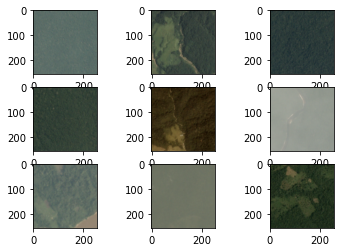

In [36]:
from matplotlib.image import imread
for i in range(9):
    plt.subplot(330 +1 + i)
    filename = train_image_datasets + 'train_' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show

In [37]:
#extraction process

datasets_list = []
for tag_values in train_datasets.tags.values:
    datasets = tag_values.split(' ')
    for dataset in datasets:
        if dataset not in datasets_list:
            datasets_list.append(dataset)

In [38]:
#checking the lenght of the data sets
len(datasets_list)

17

In [39]:
#sort the dataset

datasets_list.sort()

In [40]:
#create label that maps labels to integers and inversely
tag_mappings = {datasets_list[i]: i for i in range(len(datasets_list))}
inverse_datasets_map = {i:datasets_list[i] for i in range(len(datasets))}

In [41]:
#creating a mapping of filename to tags
def map_files(mapping_csv):
    mapping = dict()
    for i in range(len(mapping_csv)):
        name, tags = mapping_csv['image_name'][i], mapping_csv['tags'][i]
        mapping[name] = tags.split(' ')
    return mapping

file_mapping = map_files(train_datasets)

In [42]:
# one hot encoding 
def encode_one_hot(tags, mapping):
    
    #creating empty vector
    encoding = np.zeros(len(mapping), dtype = 'uint8')
    
    #mark 1 for each tag in the vector
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [43]:
%%time
#after viewing the image  dataset labels and previewing the image files themselves,
#we proced to prepare the image dataset itself

# Preparing the image dataset

# Load the images
def load_dataset(path, file_mapping, tag_mappings):
    photos = list()
    targets = list()
    
# For files in the directory
    for file in os.listdir(train_image_datasets):
        
        # Load images
        photo = load_img(path + file, target_size=(64,64))
        
        # Converting to numpy array
        photo = img_to_array(photo, dtype='uint8')
        
        # Tags
        tags = file_mapping[file[:-4]]
        
        # One hot encode tags
        target = encode_one_hot(tags, tag_mappings)
        
        #stores
        photos.append(photo)
        targets.append(target)
            
    X = np.asarray(photos,dtype='uint8')
    Y = np.asarray(targets,dtype='uint8')
    return X,Y

X, Y = load_dataset(train_image_datasets, file_mapping, tag_mappings)
print(X.shape, Y.shape)

# Compressing X and Y arrays into one single file
np.savez_compressed('planet_data.npz', X, Y)
        
        

(40479, 64, 64, 3) (40479, 17)
CPU times: user 1min 35s, sys: 2.59 s, total: 1min 38s
Wall time: 1min 49s


In [44]:
#dataset loading

data = np.load('./planet_data.npz')
X,Y = data['arr_0'], data['arr_1']
print('load_dataset: ', X.shape, Y.shape)

load_dataset:  (40479, 64, 64, 3) (40479, 17)


In [45]:
# Split datasets into training  and validation  sets

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.3, random_state = 42)
print('shapes: ', X_train.shape, X_val.shape, Y_val.shape)

shapes:  (28335, 64, 64, 3) (12144, 64, 64, 3) (12144, 17)


In [68]:

# we first consider evaluation metric as evaluation metric = Fscore
# Create a funcion to compute evaluation metrics this will make it easier and reduce error


def fbeta(Y_true, Y_pred, beta=2):
    
    #clip predictors
    Y_pred = backend.clip(Y_pred, 0, 1)
    
    #Calculating elements
    tp = backend.sum(backend.round(backend.clip(y_true * Y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_true - Y_pred, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - Y_pred, 0, 1)), axis=1)
    
    #Calculating precision
    p = tp / (tp + fp + backend.epsilon())
    
    #Calculate recall
    r = tp / (tp + fn + backend.epsilon())
    
    #Calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean(1 + bb) * (p * r) / (bb * p * r + backend.epsilon())
    
    return fbeta_score


In [51]:

# Initialise the planet and use CNN
model_planet = tf.keras.models.Sequential()

In [52]:
model_planet

In [53]:
# add conv and pooling layers
model_planet.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=[64, 64, 3]))
model_planet.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.MaxPool2D(2,2))


In [54]:
# add second conv and pooling layers
model_planet.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.MaxPool2D(2,2))

In [55]:
# add third conv and pooling layers
model_planet.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model_planet.add(tf.keras.layers.MaxPool2D(2,2))

In [56]:
# add flattening and output layers
model_planet.add(tf.keras.layers.Flatten())
model_planet.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model_planet.add(tf.keras.layers.Dense(17, activation='sigmoid'))

In [58]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from sklearn.metrics import fbeta_score
from keras.layers import Flatten
from keras.optimizers import SGD

In [59]:
# Compilled the created model_planet
opt = SGD(lr=0.01, momentum=0.9)
model_planet.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

In [60]:
# Plot learning curves
def summerize_diagostics(history):
    
    #plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    #plot accuracy
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    
    #save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()

In [61]:
#Create data generators
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

In [62]:
datagen

In [66]:

import pandas as pd

read_file = pd.read_csv (r'Path where the Text file is stored\File name.txt', header = None)
read_file.columns = ['first_column','second_column',...]
read_file.to_csv (r'Path where the CSV will be saved\File name.csv', index=None)

SyntaxError: invalid syntax (<ipython-input-66-7fc65c0d44d4>, line 1)